In [33]:
import os
import lime
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

In [34]:
batch_size = 32
dataset_code = 'A'
model_name = 'MobileNet'
data_saved_dir = r'E:\Post-Flood-Disaster-Management\Classification\pickle_data'
model_saved_dir = r'E:\Post-Flood-Disaster-Management\Classification\models'
test_data_path = f'{data_saved_dir}\\floodnet_testing.pkl'

In [35]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

test_images, test_labels = load_pickle(test_data_path)
print(f'Testing images: {test_images.shape}')

Testing images: (62, 256, 256, 3)


In [36]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

test_data_generator = CustomDataGenerator(test_images, test_labels, batch_size)

['A_MobileNet-weights-improvement-06-0.97.hdf5']
Best model loaded ...
2/2 [==============================] - 2s 452ms/step


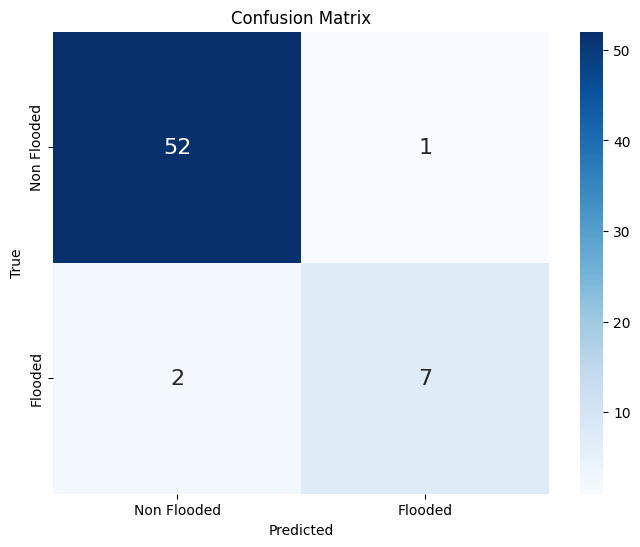

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       0.88      0.78      0.82         9

    accuracy                           0.95        62
   macro avg       0.92      0.88      0.90        62
weighted avg       0.95      0.95      0.95        62



In [37]:
model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'

models = sorted(os.listdir(model_dir))

for file in models[:-1]:
    os.remove(f'{model_dir}\{file}')

print(os.listdir(model_dir))
best_model = load_model(f'{model_dir}\{models[-1]}')
print('Best model loaded ...')

predictions = best_model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'], annot_kws={'size':16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [38]:
from lime import lime_image

X_test_images = test_data_generator[0][0]
X_test_labels = test_data_generator[0][1]

In [39]:
def apply_lime(image, label):

    explainer = lime_image.LimeImageExplainer()
    exp = explainer.explain_instance(image, 
                                    best_model.predict, 
                                    top_labels=1, 
                                    hide_color=0, 
                                    num_samples=1000)
    
    temp, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, negative_only=False, num_features=5, hide_rest=True)

    img = np.expand_dims(image, axis=0)
    predicted = "Non-Flooded"
    if (best_model.predict(img)[0][0] > 0.5):
        print(f'Predicted: Flooded with {round(best_model.predict(img)[0][0] * 100, 2)}% confidence')
        predicted = "Flooded"
    else:
        print(f'Predicted: Non-Flooded with {round((1 - best_model.predict(img)[0][0]) * 100, 2)}% confidence')

        
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)  
    plt.imshow(image)
    plt.title(f'Original Image \n Ground Truth:{"Flooded" if label == 1 else "Non-Flooded"}')

    plt.subplot(1, 2, 2)
    dict_heatmap = dict(exp.local_exp[exp.top_labels[0]])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.title(f'Heatmap \n Predicted: {predicted}')

    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 105ms/step
Predicted: Flooded with 96.85% confidence


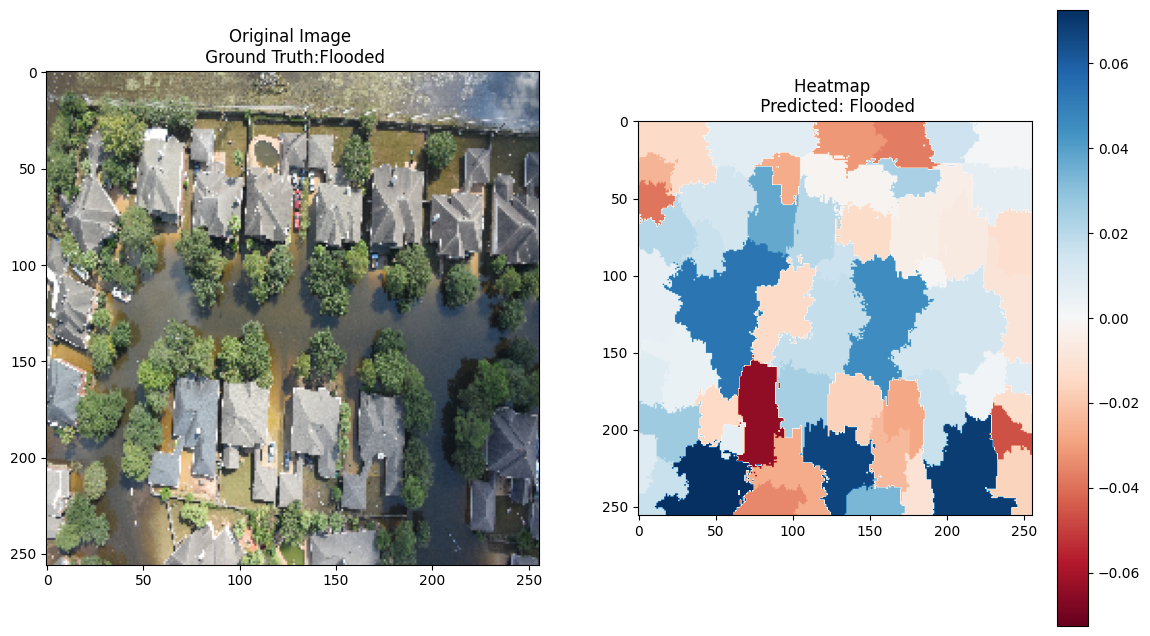

In [40]:
apply_lime(X_test_images[2], X_test_labels[2])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
Predicted: Flooded with 100.0% confidence


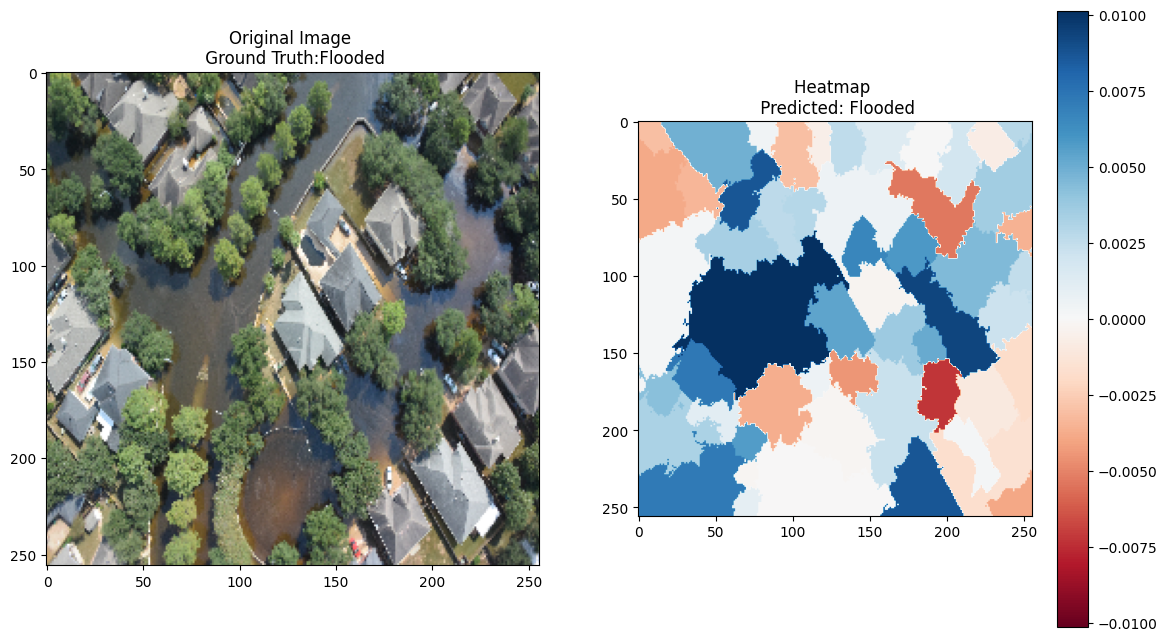

In [298]:
apply_lime(X_test_images[15], X_test_labels[15])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
Predicted: Flooded with 99.9% confidence


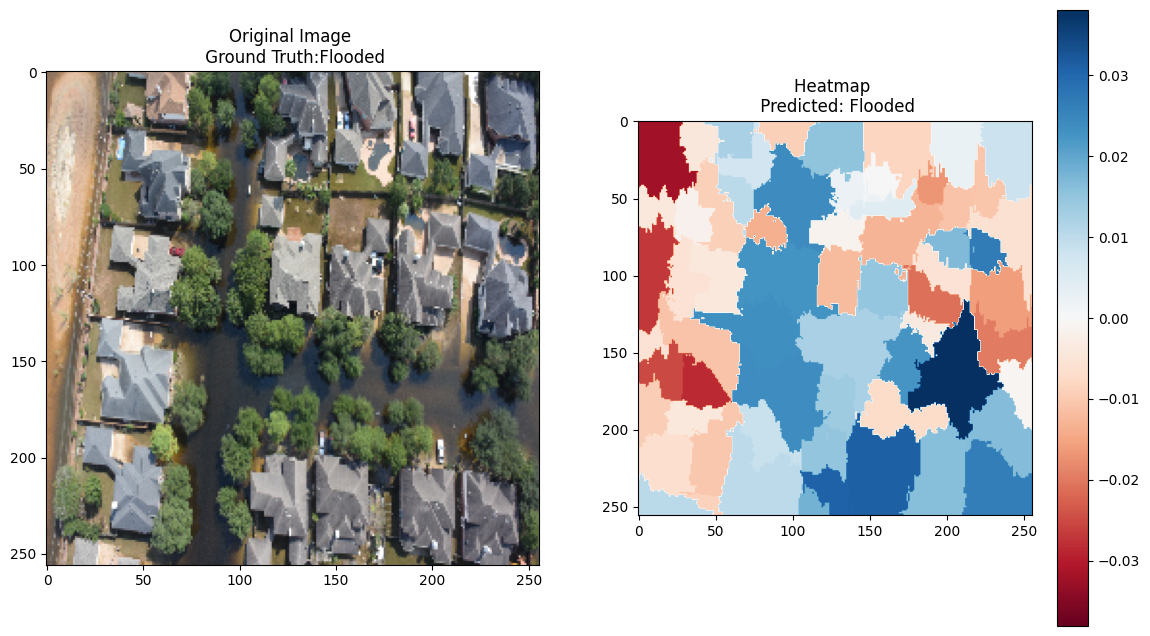

In [301]:
apply_lime(X_test_images[22], X_test_labels[22])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
Predicted: Non-Flooded with 99.94% confidence


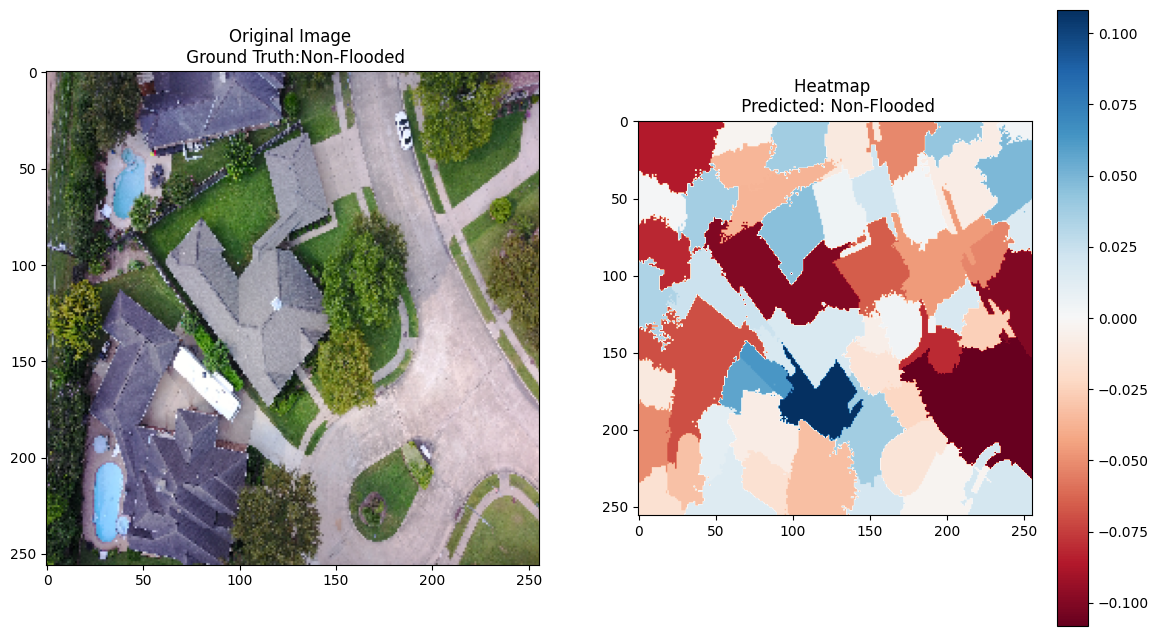

In [302]:
apply_lime(X_test_images[10], X_test_labels[10])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
Predicted: Non-Flooded with 100.0% confidence


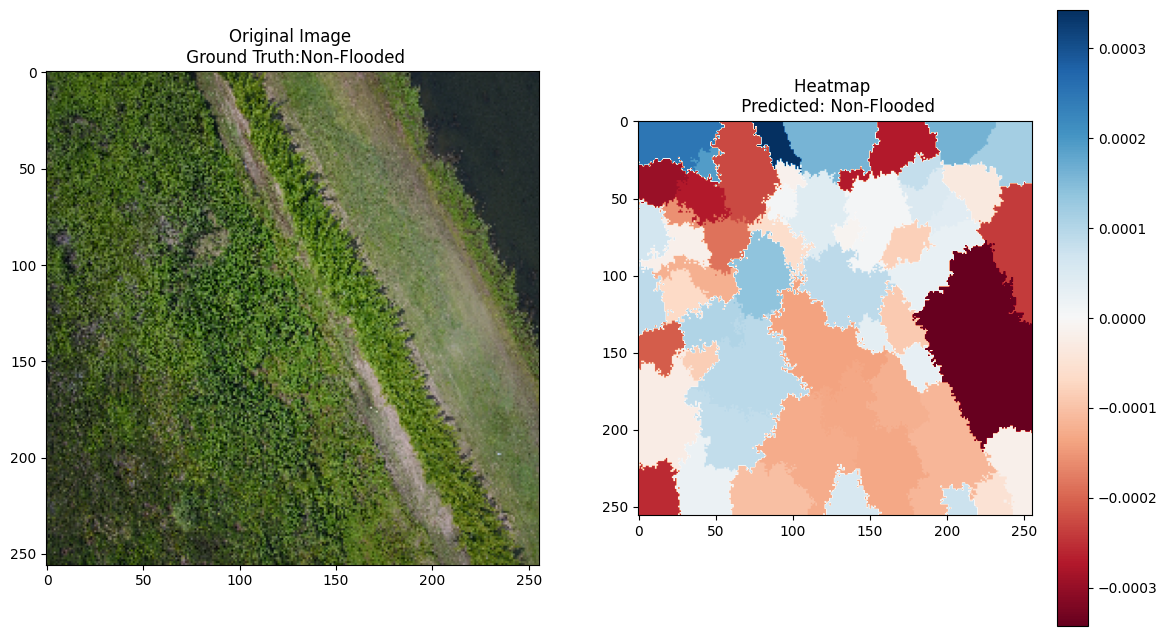

In [307]:
apply_lime(X_test_images[26], X_test_labels[26])

## Misclassified instances

###  1. FloodNet Dataset

In [41]:
for i in range(len(predictions)):
    if (predictions[i] > 0.5).astype(int)[0] != test_labels[i]:
        print(f'Index: {i} Actual: {test_labels[i]} Predicted: {((predictions[i] > 0.5).astype(int))[0]}')

Index: 34 Actual: 1 Predicted: 0
Index: 40 Actual: 1 Predicted: 0
Index: 43 Actual: 0 Predicted: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 93ms/step
Predicted: Non-Flooded with 99.97% confidence


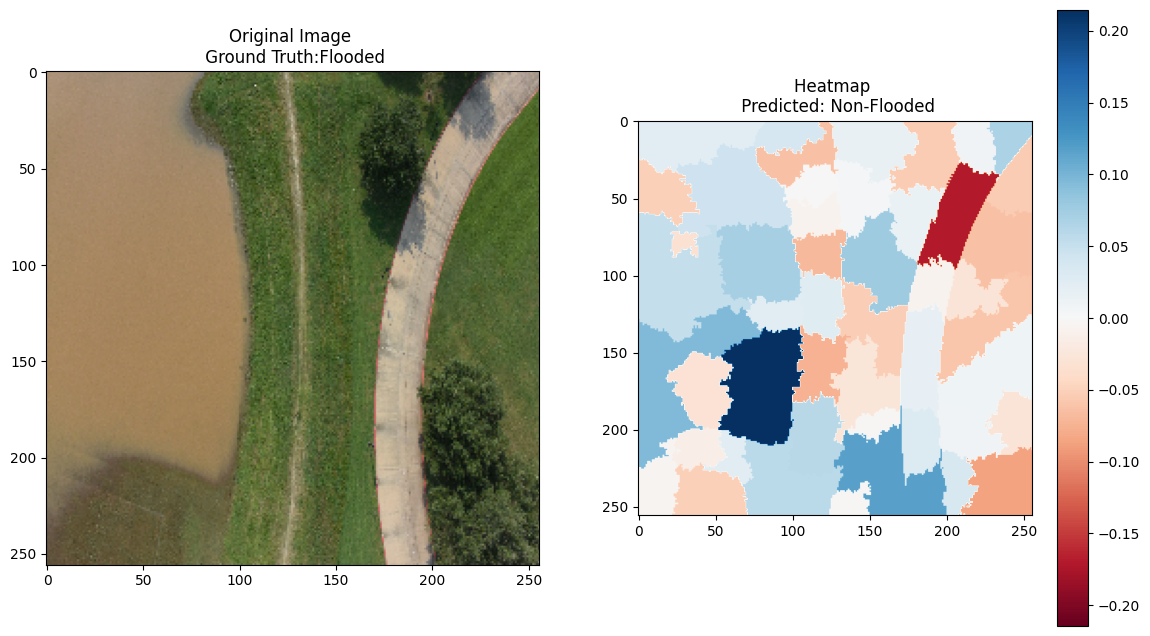

In [18]:
index = 40
apply_lime(test_images[index], test_labels[index])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step
Predicted: Flooded with 89.89% confidence


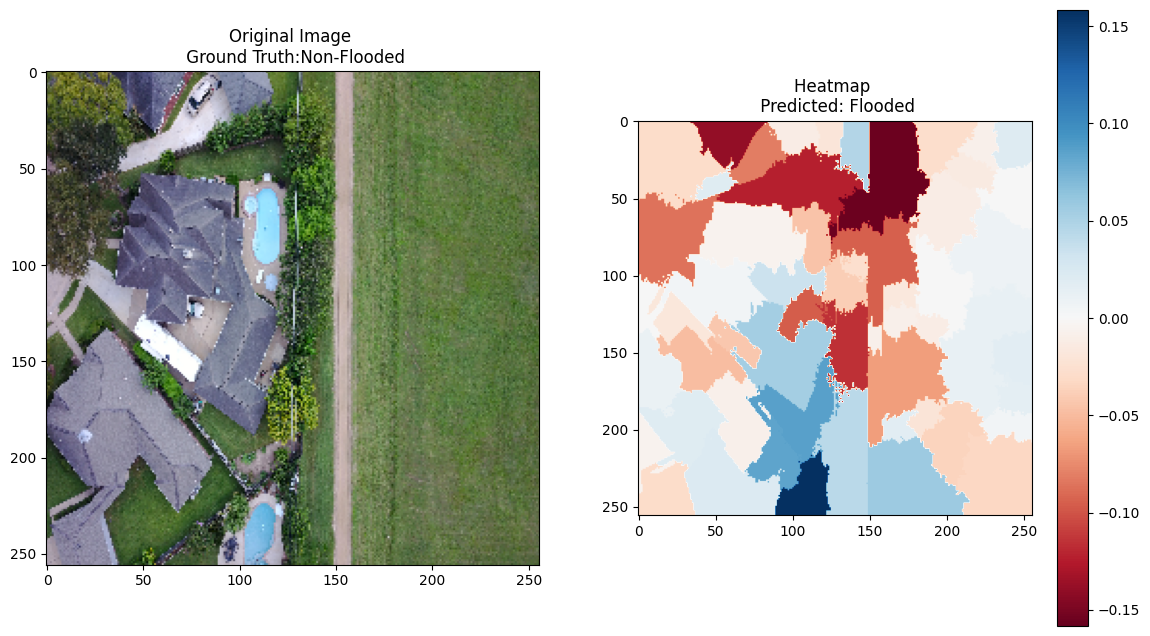

In [17]:
index = 43
apply_lime(test_images[index], test_labels[index])

### 2. AIDER dataset

In [42]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

test_data_path = f'{data_saved_dir}\\AIDER_testing.pkl'
test_images, test_labels = load_pickle(test_data_path)
print(f'Testing images: {test_images.shape}')

Testing images: (739, 256, 256, 3)


['A_MobileNet-weights-improvement-06-0.97.hdf5']
Best model loaded ...
24/24 [==============================] - 12s 491ms/step


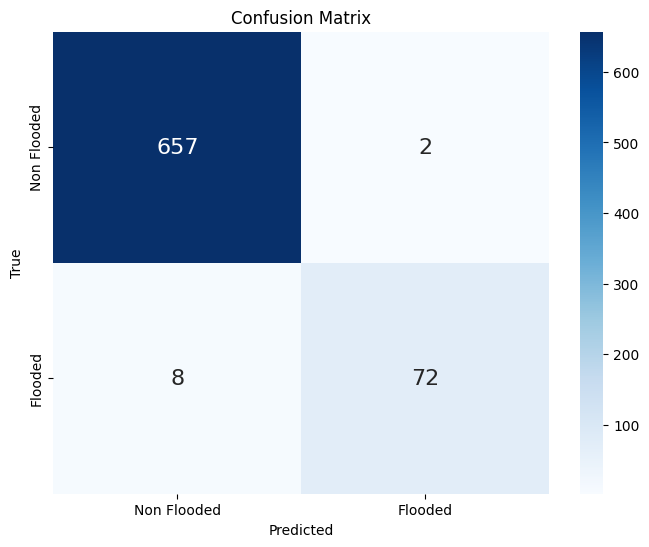

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       659
           1       0.97      0.90      0.94        80

    accuracy                           0.99       739
   macro avg       0.98      0.95      0.96       739
weighted avg       0.99      0.99      0.99       739



In [43]:
model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'

models = sorted(os.listdir(model_dir))

for file in models[:-1]:
    os.remove(f'{model_dir}\{file}')

print(os.listdir(model_dir))
best_model = load_model(f'{model_dir}\{models[-1]}')
print('Best model loaded ...')

predictions = best_model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'], annot_kws={'size':16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [45]:
for i in range(len(predictions)):
    if (predictions[i] > 0.5).astype(int)[0] != test_labels[i]:
        print(f'Index: {i} Actual: {test_labels[i]} Predicted: {((predictions[i] > 0.5).astype(int))[0]}')

Index: 211 Actual: 1 Predicted: 0
Index: 270 Actual: 0 Predicted: 1
Index: 285 Actual: 1 Predicted: 0
Index: 317 Actual: 1 Predicted: 0
Index: 359 Actual: 1 Predicted: 0
Index: 401 Actual: 1 Predicted: 0
Index: 483 Actual: 1 Predicted: 0
Index: 608 Actual: 1 Predicted: 0
Index: 650 Actual: 0 Predicted: 1
Index: 672 Actual: 1 Predicted: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 89ms/step
Predicted: Non-Flooded with 99.99% confidence


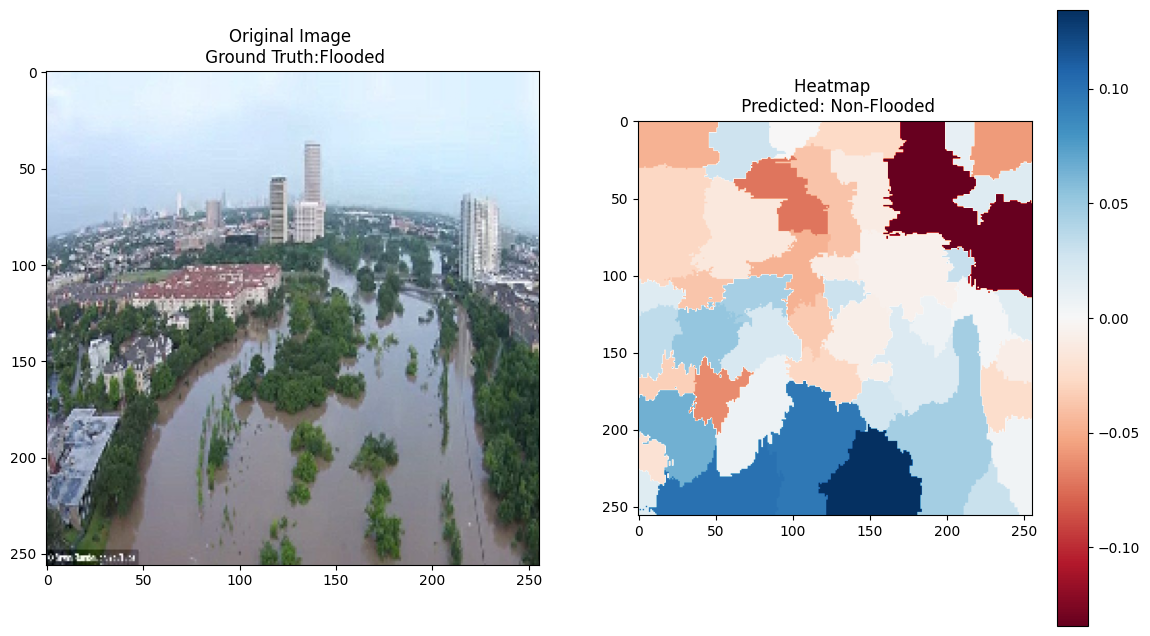

In [46]:
index = 211
apply_lime(test_images[index], test_labels[index])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 99ms/step
Predicted: Flooded with 85.09% confidence


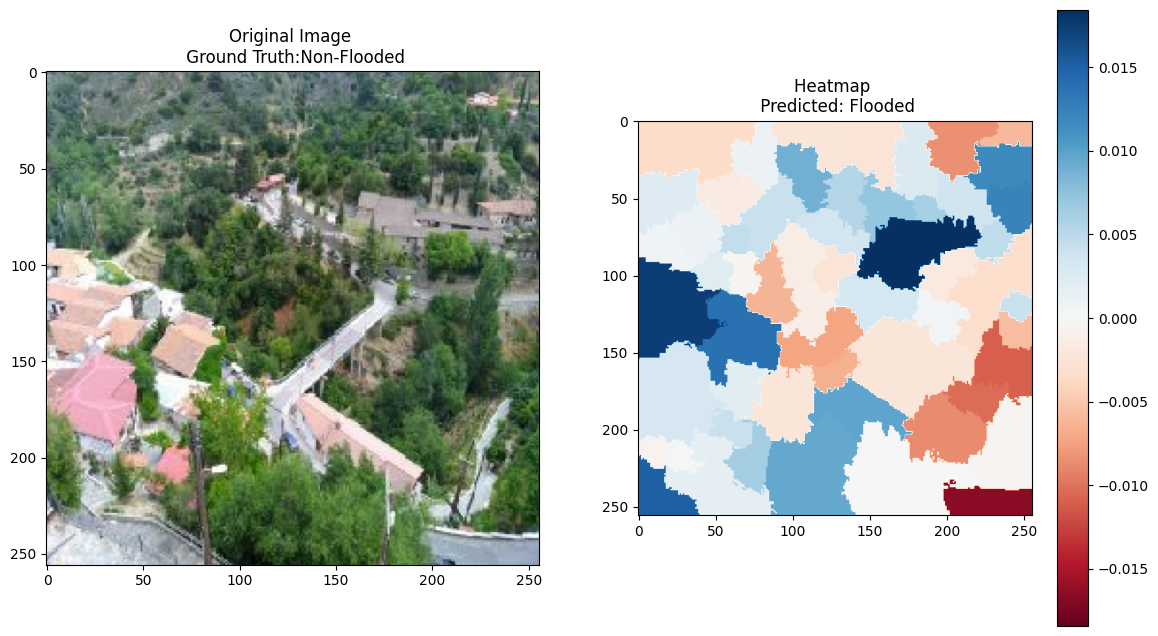

In [48]:
index = 650
apply_lime(test_images[index], test_labels[index])

### 3. Google Images

In [49]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

test_data_path = f'{data_saved_dir}\\Downloaded_testing.pkl'
test_images, test_labels = load_pickle(test_data_path)
print(f'Testing images: {test_images.shape}')

Testing images: (145, 256, 256, 3)


['B_MobileNet-weights-improvement-05-0.95.hdf5']
Best model loaded ...
5/5 [==============================] - 3s 429ms/step


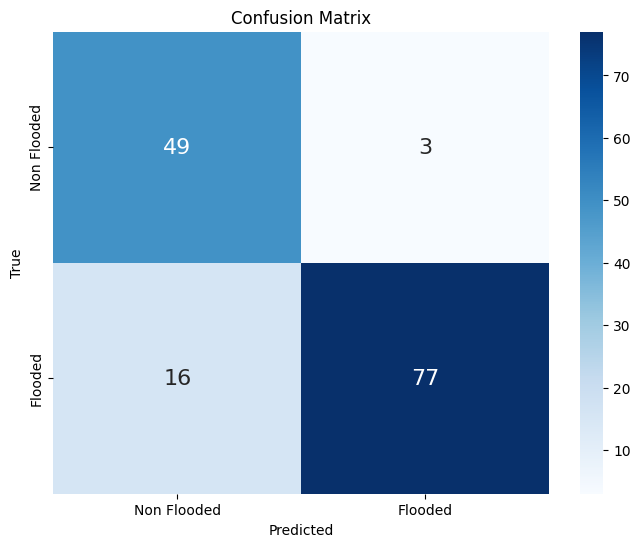

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.84        52
           1       0.96      0.83      0.89        93

    accuracy                           0.87       145
   macro avg       0.86      0.89      0.86       145
weighted avg       0.89      0.87      0.87       145



In [50]:
dataset_code = 'B'
model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'

models = sorted(os.listdir(model_dir))

for file in models[:-1]:
    os.remove(f'{model_dir}\{file}')

print(os.listdir(model_dir))
best_model = load_model(f'{model_dir}\{models[-1]}')
print('Best model loaded ...')

predictions = best_model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'], annot_kws={'size':16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [51]:
for i in range(len(predictions)):
    if (predictions[i] > 0.5).astype(int)[0] != test_labels[i]:
        print(f'Index: {i} Actual: {test_labels[i]} Predicted: {((predictions[i] > 0.5).astype(int))[0]}')

Index: 9 Actual: 1 Predicted: 0
Index: 10 Actual: 1 Predicted: 0
Index: 13 Actual: 1 Predicted: 0
Index: 20 Actual: 1 Predicted: 0
Index: 37 Actual: 0 Predicted: 1
Index: 41 Actual: 1 Predicted: 0
Index: 43 Actual: 1 Predicted: 0
Index: 62 Actual: 0 Predicted: 1
Index: 69 Actual: 1 Predicted: 0
Index: 75 Actual: 1 Predicted: 0
Index: 86 Actual: 1 Predicted: 0
Index: 87 Actual: 1 Predicted: 0
Index: 89 Actual: 1 Predicted: 0
Index: 92 Actual: 1 Predicted: 0
Index: 97 Actual: 1 Predicted: 0
Index: 98 Actual: 1 Predicted: 0
Index: 110 Actual: 1 Predicted: 0
Index: 117 Actual: 1 Predicted: 0
Index: 123 Actual: 0 Predicted: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 91ms/step
Predicted: Non-Flooded with 100.0% confidence


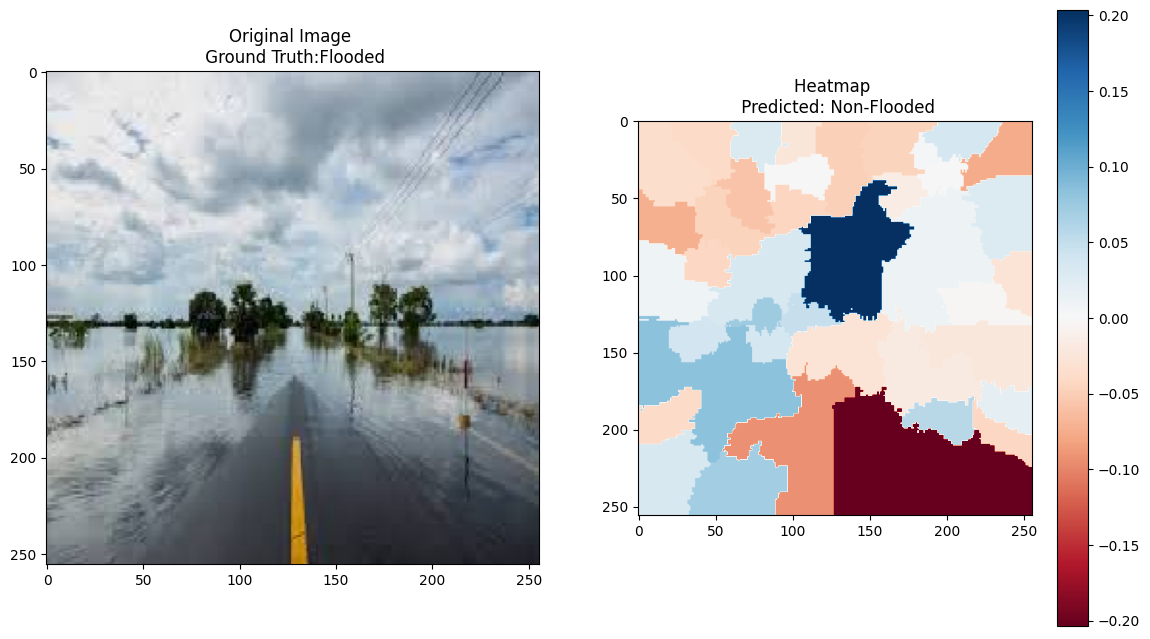

In [52]:
index = 9
apply_lime(test_images[index], test_labels[index])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 107ms/step
Predicted: Flooded with 100.0% confidence


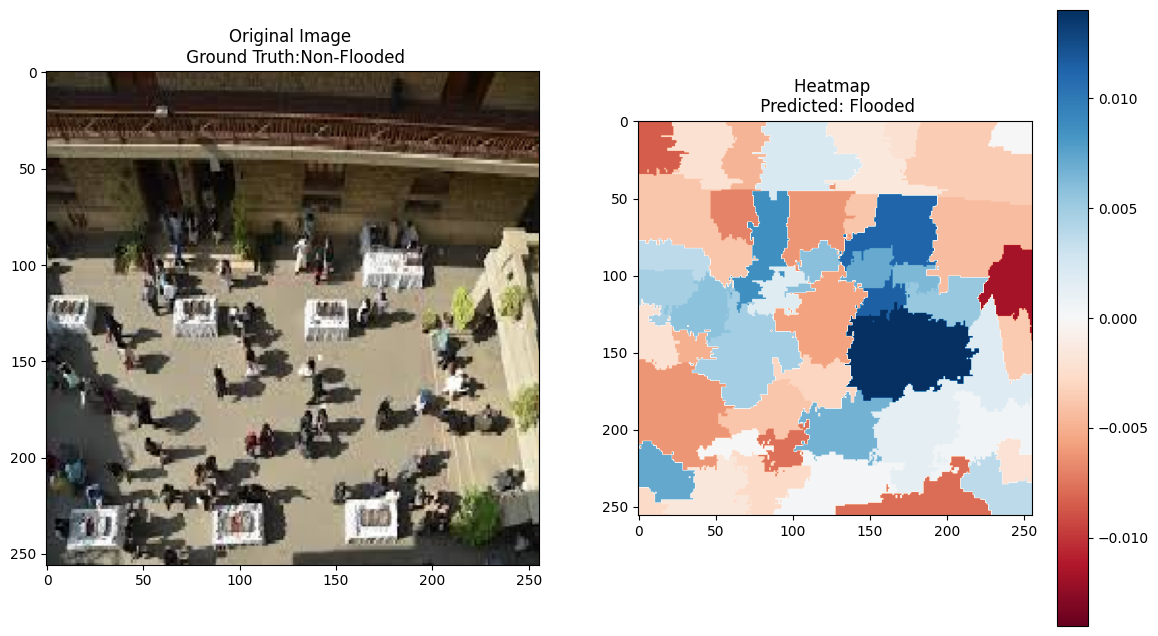

In [54]:
index = 123
apply_lime(test_images[index], test_labels[index])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 127ms/step
Predicted: Non-Flooded with 100.0% confidence


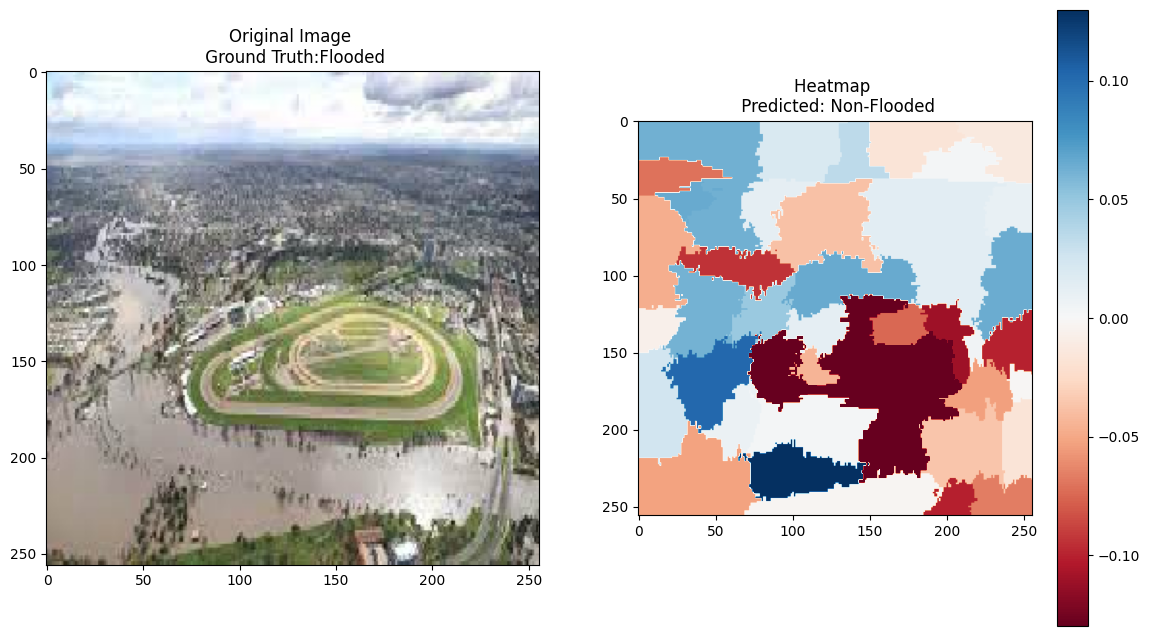

In [56]:
index = 98
apply_lime(test_images[index], test_labels[index])